README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7600 [00:00<?, ? examples/s]

Vocabulary size: 50002
Training model...


100%|██████████| 938/938 [10:35<00:00,  1.48it/s]


Epoch 1/5 Loss: 0.46971575979357844


100%|██████████| 938/938 [10:36<00:00,  1.47it/s]


Epoch 2/5 Loss: 0.2450398156590172


100%|██████████| 938/938 [10:35<00:00,  1.48it/s]


Epoch 3/5 Loss: 0.1897608844011323


100%|██████████| 938/938 [10:36<00:00,  1.47it/s]


Epoch 4/5 Loss: 0.147526209534549


100%|██████████| 938/938 [10:35<00:00,  1.48it/s]


Epoch 5/5 Loss: 0.11315506586689812
Evaluating model...
Accuracy: 0.9100
F1 Score: 0.9099
Precision: 0.9102
Recall: 0.9100


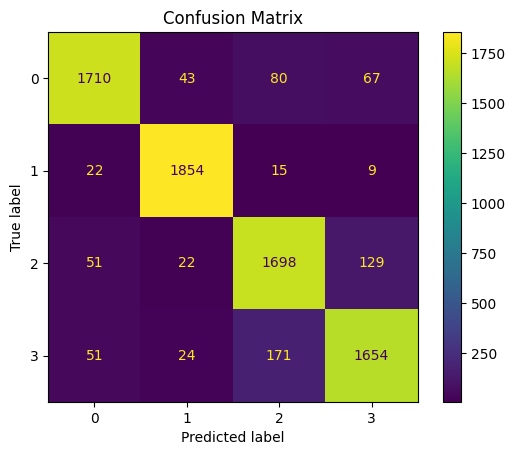

In [2]:
import os
import random
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from datasets import load_dataset
from collections import Counter
import string
import warnings

warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the AG News dataset
dataset = load_dataset('ag_news')

# Filter out any NaN values
train_dataset = dataset['train'].filter(lambda x: x['text'] is not None and x['label'] is not None)
test_dataset = dataset['test'].filter(lambda x: x['text'] is not None and x['label'] is not None)

# Use a subset for training and testing
train_dataset = train_dataset.shuffle(seed=42).select(range(120000))
test_dataset = test_dataset

# Tokenizer: Build Vocabulary
def basic_tokenizer(text):
    text = text.lower().translate(str.maketrans("", "", string.punctuation))
    return text.split()

def build_vocab(dataset, max_vocab_size=50000):
    counter = Counter()
    for example in dataset['text']:
        tokens = basic_tokenizer(example)
        counter.update(tokens)
    most_common = counter.most_common(max_vocab_size)
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}  # Reserve 0 for [PAD], 1 for [UNK]
    vocab["[PAD]"] = 0
    vocab["[UNK]"] = 1
    return vocab

vocab = build_vocab(train_dataset, max_vocab_size=50000)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Custom Tokenizer
def custom_tokenizer(text, vocab, max_length=99):
    tokens = basic_tokenizer(text)
    token_ids = [vocab.get(token, vocab["[UNK]"]) for token in tokens]
    if len(token_ids) < max_length:
        token_ids += [vocab["[PAD]"]] * (max_length - len(token_ids))  # Padding
    else:
        token_ids = token_ids[:max_length]  # Truncate
    return token_ids

# Tokenize Dataset
def tokenize_custom_dataset(dataset, vocab, max_length=99):
    tokenized_data = []
    for example in dataset:
        tokenized_data.append({
            'input_ids': custom_tokenizer(example['text'], vocab, max_length),
            'labels': example['label']
        })
    return tokenized_data

tokenized_train_data = tokenize_custom_dataset(train_dataset, vocab)
tokenized_test_data = tokenize_custom_dataset(test_dataset, vocab)

# Convert to PyTorch Dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.data[idx]['input_ids'], dtype=torch.long),
            'labels': torch.tensor(self.data[idx]['labels'], dtype=torch.long)
        }

train_dataset = CustomDataset(tokenized_train_data)
test_dataset = CustomDataset(tokenized_test_data)

# DataLoader
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Cyclic Attention Block with Gating Mechanism
class CyclicAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(CyclicAttentionBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.gate = nn.Linear(embed_dim, 1)  # Gating mechanism

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm(x + attn_output)
        cyclic_term = torch.roll(attn_output, shifts=1, dims=0)
        g = torch.sigmoid(self.gate(attn_output))  # Apply gating
        x = self.norm(x + g * cyclic_term)
        return self.dropout(x)

# Transformer Block with Cyclic Attention
class CombinedTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(CombinedTransformerBlock, self).__init__()
        self.attention1 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.cyclic_attention = CyclicAttentionBlock(embed_dim, num_heads, dropout)
        self.attention2 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attention1(x, x, x)
        x = self.norm1(x + attn_output)
        x = self.cyclic_attention(x)
        attn_output, _ = self.attention2(x, x, x)
        x = self.norm2(x + attn_output)
        ff_output = self.ff(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

# Custom Transformer Model
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_classes, max_length, num_layers):
        super(CustomTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.layers = nn.ModuleList([
            CombinedTransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ])
        self.global_pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = x.permute(1, 0, 2)
        for layer in self.layers:
            x = layer(x)
        x = x.permute(1, 2, 0)
        x = self.global_pooling(x).squeeze(-1)
        logits = self.fc(x)
        return logits

# Initialize custom Transformer model
embed_dim = 1024
num_heads = 8
ff_dim = 2048
num_classes = 4
max_length = 99
num_layers = 3
epochs = 5

model = CustomTransformer(vocab_size, embed_dim, num_heads, ff_dim, num_classes, max_length, num_layers).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Training
print("Training model...")
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        logits = model(input_ids)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs} Loss: {total_loss / len(train_loader)}")

# Evaluation
print("Evaluating model...")
model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_ids)
        all_logits.append(logits)
        all_labels.append(labels)

all_logits = torch.cat(all_logits)
all_labels = torch.cat(all_labels)

predictions = torch.argmax(all_logits, dim=1).cpu().numpy()
true_labels = all_labels.cpu().numpy()

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix")
plt.show()
